# Figure 6E: Plot boid-boid avoidance.

We plot the relationship between position displacement between a boid and flock and its subsequent velocity(t+1).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as functional
from torch.utils.data import random_split
from torch_geometric.data import Batch, Data, DataLoader

In [3]:
import os
import sys

script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env/gnn")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")
sys.path.append("/workspace/collab-environment/figures")

In [4]:
from collab_env.data.file_utils import expand_path, get_project_root

In [7]:
from collab_env.data.boids.animal_simulation import visualize_graph, visualize_pair
from collab_env.gnn.gnn import (get_adjcency_from_debug, plot_log_loss, train_rules_gnn,
    identify_frames, find_frame_sets, load_model, debug_result2prediction)
from utility import handle_discrete_data
from collab_env.gnn.gnn_definition import GNN, Lazy
from collab_env.data.boids.animal_simulation import visualize_graph_2sets
from figures.gnn.plot_helpers import (rollout_to_pos_vel_acc,
    data_to_pos_vel_acc,
    return_deltapos_vnext,
    figure_data_C)
from collab_env.data.file_utils import expand_path, get_project_root
from collab_env.gnn.plotting_utility import load_various_data, load_rollout

## Data

#### a) without food, boid
#### b) without food, independent
#### c) with food, boid
#### d) with food, independent

In [8]:
data_names = ['boid_single_species_basic']
              #'boid_single_species_weak_alignment',
              #'boid_single_species_strong_alignment']#, 'boid_single_species_independent', # without food
              #'boid_food_basic_alignment', 'boid_food_basic_independent', # with food
              #'boid_food_strong'] # with food, strong influence


rollout_results =  {}
data = {}
model_names = ["boid"] #["weak", "medium", "strong"]


for ind in range(len(data_names)):
    spec = {
        "data_name": data_names[ind],
        "head": 1,
        "visual_range": 0.1,
        "seed": 0,
        "rollout_starting_frame": 5,
        "noise": 0
    }
    
    
    rollout_results[model_names[ind]] = load_rollout("vpluspplus_a", **spec)

    data[model_names[ind]] = load_various_data(data_names, 1)

/workspace/conda/envs/gnn/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [16]:
START_FRAME = 5
END_FRAME = 55
plotting_kwargs = {
    "starting_frame": START_FRAME,
    "ending_frame": END_FRAME,
    "subsample": 1
}

In [17]:
# parse alignment
(delta_p_data, vnext_data,
 delta_p_model, vnext_model) = ({}, {}, {}, {})

for model in model_names:

    """data"""
    plotting_kwargs["model"] = False
    test_loader = data[model]["test_loader"] 
    delta_p_data[model], vnext_data[model] = figure_data_C(test_loader, None, **plotting_kwargs)

    """model"""
    plotting_kwargs["model"] = True
    result = rollout_results[model]
    delta_p_model[model], vnext_model[model] = figure_data_C(None, result, **plotting_kwargs)

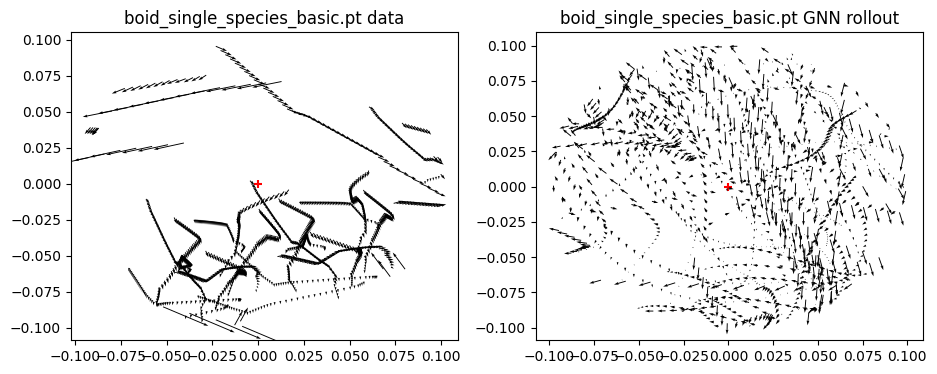

In [20]:
fig, axes = plt.subplots(len(model_names), 2, figsize = (11, 4 * len(model_names)))
axes = axes.reshape((-1,2))

ind = 0
for model in model_names:
    axes[ind, 0].scatter(0,0,marker = '+',c = 'r')
    p = delta_p_data[model]
    v = vnext_data[model]
    axes[ind, 0].quiver(p[:,0],p[:,1],
                   v[:,0]*10,v[:,1]*10)
    
    
    axes[ind, 1].scatter(0,0,marker = '+',c = 'r')
    p = delta_p_model[model]
    v = vnext_model[model]
    
    axes[ind, 1].quiver(p[:,0],p[:,1],
                   v[:,0]*10,v[:,1]*10)
    
    axes[ind, 0].set_title(data[model]['file_name'] + ' data')
    axes[ind, 1].set_title(data[model]['file_name'] + ' GNN rollout')

    ind = ind + 1


In [ ]:
# - subsample: every 1/10: repulsion

# - make more files to do rollout. restrict to 50 